# Data preprocessing

In [0]:
# import of necessary libraries
import io
import pandas as pd
from datetime import datetime
import numpy as np

# data download
df_prod = pd.read_csv('products.txt', sep= "|" )
df_trns = pd.read_csv('transactions.txt', sep= "|" )
df_users = pd.read_csv('users.txt', sep= "|" )

In [0]:
# merging of two data frames
new = pd.merge(df_trns, df_users, on="ID_user") 

In [0]:
# data cleaning
df = new[new.age != 0]

In [0]:
# creating a new dataframe to find the CLV 
new['txn_time'] = pd.to_datetime(df['txn_time'])
new_data = df.groupby('ID_user')['txn_time'].agg(['min','max', ]).rename(columns={'min':'first','max':'last'})

In [269]:
# checking the results
#new_data
df

,ID_txn,ID_user,txn_time,ID_product,price,gender,age
0,21000723509,9115418,2011-12-03 00:27:00,5135708,637.0,male,38.0
1,21011382974,9115418,2013-01-28 14:35:00,5685341,897.0,male,38.0
2,21008412494,9115418,2012-11-29 19:18:00,1291238,9087.0,male,38.0
3,21011723936,9115418,2013-02-03 23:36:00,1736522,14677.0,male,38.0
4,21019040462,9115418,2013-06-28 18:42:00,3104336,3497.0,male,38.0
...,...,...,...,...,...,...,...
42879,6638189,102443513,2011-09-20 10:40:00,116477,1625.0,female,27.0
42880,6682439,129347549,2011-09-22 15:07:00,124289,3887.0,male,28.0
42888,10376072,252434387,2012-03-29 09:38:00,281684,5187.0,female,31.0
42895,4689851,50896058,2011-05-12 12:50:00,64817,5187.0,male,52.0


In [0]:
# merging of two data frames
#new_data = (new_data.merge(df, left_on='first', right_on='txn_time').reindex(columns=['first', 'last', 'age']))
new_data = (new_data.merge(df, left_on='first', right_on='txn_time').reindex(columns=['first', 'last', 'age', 'gender', 'price', 'ID_product']))

In [0]:
# convert to time so that we can then make a subtraction
new_data['first'] = pd.to_datetime(new_data['first'])
new_data['last'] = pd.to_datetime(new_data['last'])

In [0]:
# making a difference, ie CLV
new_data['duration'] = new_data['last'] - new_data['first'] 
new_data['duration'] = new_data['duration'] / np.timedelta64(1, 'D') 

# creating a column 'Observed', which shows us whether CL V> = 100, if so - 1, otherwise 0
new_data['observed'] = np.where(new_data['duration']>=100, 1, 0)

In [0]:
# check if there are any null
#new_data.isnull()
#new_data[new_data['age'].isnull()]

# delete rows where the columns have null
new_data.dropna(subset = ["age"], inplace=True)
#new_data.dropna(subset = ["gender"], inplace=True)

In [0]:
# elete rows where the columns have unkwnown
new_data = new_data[new_data.gender != 'unknown']

In [0]:
# transformation in dummy variable
new_data['gender'].replace({0:'Female',1:'Male'},inplace=True)

In [0]:
new_data['dumm_gender'] = np.where(new_data['gender']=='female', 0, 1)
#new_data['gender_+_wall'] = (new_data['dumm_gender'] == 1) & (new_data['observed'] == 1)

In [0]:
new_data
new_data['wall_male'] = (new_data['dumm_gender'] == 1) & (new_data['observed'] == 1) 
new_data['wall_female'] = (new_data['dumm_gender'] == 0) & (new_data['observed'] == 1) 

new_data['wall_male_bool'] = np.where(new_data['wall_male']==True, 1, 0)  
new_data['wall_female_bool'] = np.where(new_data['wall_female']==True, 1, 0)   

In [0]:
#del new_data['gender_+_wall']
del new_data['wall_male']
del new_data['wall_female']
del new_data['gender']

In [279]:
new_data
#df_dummy = pd.get_dummies(new_data, drop_first=True)

,first,last,age,price,ID_product,duration,observed,dumm_gender,wall_male_bool,wall_female_bool
0,2014-06-09 21:58:00,2015-03-13 21:03:00,28.0,29887.0,13269470,276.961806,1,1,1,0
1,2011-06-01 21:44:00,2015-04-03 07:26:00,33.0,2340.0,73931,1401.404167,1,0,0,1
2,2011-02-06 17:56:00,2014-11-26 08:40:00,45.0,20670.0,34556,1388.613889,1,1,1,0
3,2010-07-08 12:12:00,2015-03-27 22:46:00,33.0,1560.0,1250,1723.440278,1,1,1,0
4,2011-02-10 11:39:00,2015-04-14 17:18:00,31.0,3237.0,39176,1524.235417,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...
2462,2015-01-13 13:37:00,2015-01-13 13:37:00,26.0,2587.0,17467706,0.000000,0,0,0,0
2463,2015-01-15 17:32:00,2015-01-15 17:32:00,37.0,2587.0,16287380,0.000000,0,0,0,0
2464,2015-02-02 15:52:00,2015-02-02 15:52:00,29.0,6487.0,17618318,0.000000,0,0,0,0
2465,2015-04-18 23:56:00,2015-04-18 23:56:00,60.0,1027.0,19214864,0.000000,0,0,0,0


# Estimators

## KaplanMeierFitter

In [0]:
#!pip install lifelines
from lifelines import KaplanMeierFitter

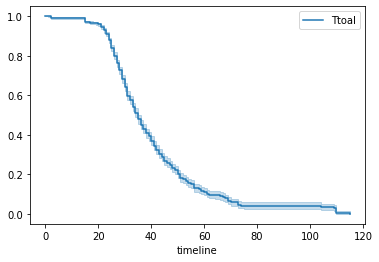

In [281]:
# Analysis by age
kmf = KaplanMeierFitter()
T = new_data["age"]
E = new_data["observed"]

kmf.fit(T, event_observed=E,label='Ttoal')
kmf.plot()

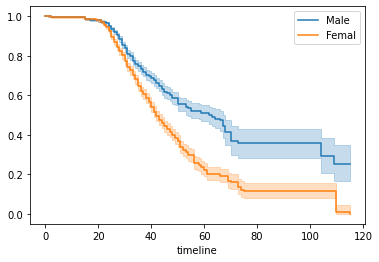

In [282]:
# Analysis by age and sex
kmf1 = KaplanMeierFitter() 


T = new_data["age"]
E1 = new_data["wall_male_bool"]
E2 = new_data["wall_female_bool"]

## fit the model for 1st cohort
kmf1.fit(T, E1, label='Male')
a1 = kmf1.plot()

## fit the model for 2nd cohort
kmf1.fit(T, E2, label='Femal')
kmf1.plot(ax=a1)

### Conclusion

Thus, from the graphs, we can conclude that it is more likely that Customer Life Value> = 100 days will be for customers, the age group, which is characterized by 20-40

As for which gender predominates, the graphs show that it is more male.

If I had more time, I would create a ratio that shows how long a person stays in the company, which would not analyze in general and by specific weeks, or also try to analyze based on products and relevant groups and the number of transactions.

## CoxPHFitter


In [0]:
del new_data['first']
del new_data['last']

In [284]:
new_data

,age,price,ID_product,duration,observed,dumm_gender,wall_male_bool,wall_female_bool
0,28.0,29887.0,13269470,276.961806,1,1,1,0
1,33.0,2340.0,73931,1401.404167,1,0,0,1
2,45.0,20670.0,34556,1388.613889,1,1,1,0
3,33.0,1560.0,1250,1723.440278,1,1,1,0
4,31.0,3237.0,39176,1524.235417,1,0,0,1
...,...,...,...,...,...,...,...,...
2462,26.0,2587.0,17467706,0.000000,0,0,0,0
2463,37.0,2587.0,16287380,0.000000,0,0,0,0
2464,29.0,6487.0,17618318,0.000000,0,0,0,0
2465,60.0,1027.0,19214864,0.000000,0,0,0,0


In [285]:
from lifelines import CoxPHFitter

cph = CoxPHFitter()
cph.fit(new_data, duration_col='age', event_col='observed')

/usr/local/lib/python3.6/dist-packages/lifelines/utils/__init__.py:1115: ConvergenceWarning: Column wall_female_bool have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['observed'].astype(bool)
>>> print(df.loc[events, 'wall_female_bool'].var())
>>> print(df.loc[~events, 'wall_female_bool'].var())

A very low variance means that the column wall_female_bool completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/lifelines/fitters/coxph_fitter.py:697: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.653. This may imply non-unique solutions to the maximum likelihood. Perhaps there is col

<lifelines.CoxPHFitter: fitted with 2367 total observations, 816 right-censored observations>

In [286]:
cph.print_summary()

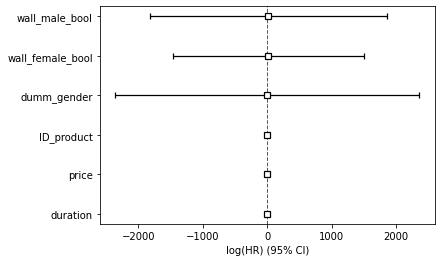

In [287]:
cph.plot()

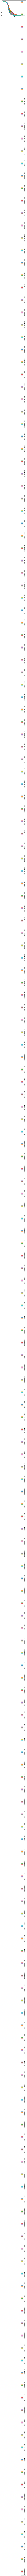

In [288]:
cph.predict_survival_function(new_data).plot()

In [0]:
del new_data['dumm_gender']
del new_data['wall_male_bool']
del new_data['wall_female_bool']

In [290]:
cph = CoxPHFitter()
cph.fit(new_data, duration_col='age', event_col='observed')

<lifelines.CoxPHFitter: fitted with 2367 total observations, 816 right-censored observations>

In [291]:
cph.print_summary()

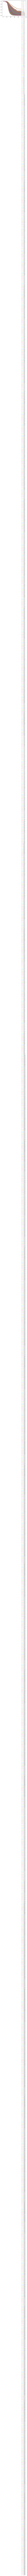

In [292]:
cph.predict_survival_function(new_data).plot()

### Conclusion

The distribution is quite large, probably due to the large distribution of products and, accordingly, the distribution of customers.

Perhaps the following analysis, with additional knowledge of how to work correctly with the domain, will give better results.
